In [1]:

import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from collections import deque
import heapq
random.seed(42)

# DO NOT ADD OTHER VARIABLES HERE

# General settings
seed = 42
image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 30
unsafe_iterations = 3

# Task 3 - BFS
bfs_n = 9
bfs_start_node = 2
bfs_end_node = 73

# Task 4 - PRM and Dijkstra
prm_total_nodes_count = 500
prm_connection_radius = 100
prm_start_location = (80,250)
prm_goal_location = (650, 350)

# Task 5 - RRT
rrt_max_nodes_count = 500
rrt_step_size = 40
rrt_max_connection_length = 200
rrt_start_location = (50,50)
rrt_goal_location = (450,450)

# DO NOT ADD OTHER VARIABLES HERE


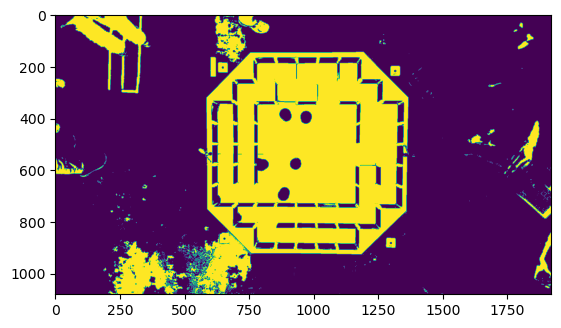

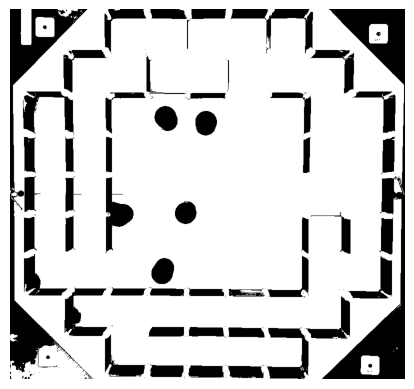

True

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("image.png")
original = img.copy()

# Convert BGR to HSV for easier color filtering
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define blue hue range (tweak if needed)
lower_blue = np.array([90, 50, 50])   # Lower bound for blue
upper_blue = np.array([130, 255, 255])  # Upper bound for blue

# Create mask of blue areas
blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Invert mask so blue areas become black (0) and rest stays
img_no_blue = img.copy()
img_no_blue[blue_mask > 0] = [255, 255, 255]  # Set blue pixels to black

# Convert to grayscale after removing blue
gray = cv2.cvtColor(img_no_blue, cv2.COLOR_BGR2GRAY)

# Apply binary threshold
_, bw_maze = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)

# Crop region
# Show result
plt.imshow(bw_maze)
plt.show()
bw_maze = bw_maze[170:910, 580:1370] 

#crop the stupid line
cv2.line(bw_maze, (0, 840), (2000, 845), (255, 255, 255), 20)




plt.imshow(bw_maze, cmap='gray')
plt.axis('off')
plt.show()

# Save
cv2.imwrite("maze_bw.png", bw_maze)


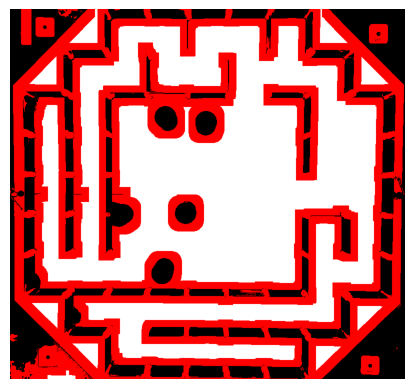

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Morphological kernel for erosion
morph_kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8) 

# Keep a copy before erosion
before = bw_maze.copy()

# Apply erosion
image = cv2.erode(bw_maze, morph_kernel)

# Compute difference (absolute per pixel)
diff = cv2.absdiff(before, image)  # <-- compare before vs eroded

# --- Detect white pixels safely ---
if diff.ndim == 3 and diff.shape[2] == 3:
    white_mask = np.all(diff == [255, 255, 255], axis=2)
else:
    white_mask = diff == 255

# Ensure image is 3-channel for coloring
if image.ndim == 2 or image.shape[2] == 1:  # grayscale
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
else:
    color_image = image.copy()

# Apply red border
color_image[white_mask] = [0, 0, 255]  # BGR red

# Display
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [4]:
# Task 2.1 (0 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id1 not in self.edges:
                self.edges[node_id1] = {}
            self.edges[node_id1][node_id2] = weight

            if node_id2 not in self.edges:
                self.edges[node_id2] = {}
            self.edges[node_id2][node_id1] = weight


    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            del self.edges[node_id1][node_id2]
            
        if node_id2 in self.edges and node_id1 in self.edges[node_id2]:
            del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.values())
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None


In [5]:
# This is a useful function that you may choose to implement and use 
# It looks through the image to see if the path is clear between one coordinate to the next
# Returns True or False 
def path_clear(image, x1, y1, x2, y2):
    num_points = int(((x2 - x1)**2 + (y2 - y1)**2)**0.5) # number of points to sample along the line (smaller sample for smaller lines)
    
    # Equally spaced x and y values, then cast it to integer
    x_vals = np.linspace(x1, x2, num_points).astype(np.int32)
    y_vals = np.linspace(y1, y2, num_points).astype(np.int32)
    
    # Check if it is not white and return false for clear path
    for x, y in zip(x_vals, y_vals):
        if image[y, x] != 255:  # In grayscale, 255 means white
            return False
    return True




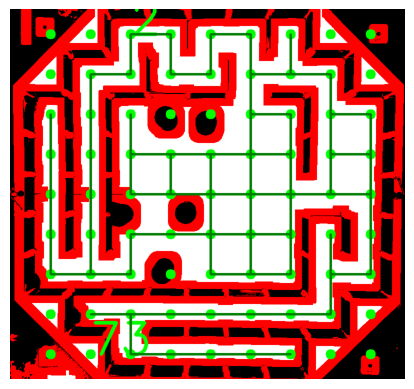

In [6]:
# Make a color copy of your maze in BGR for drawing
bfs_image = color_image.copy()  # already BGR from earlier code
bfs_graph = Graph()
img_height, img_width = bfs_image.shape[:2]
spacing = (min(img_width, img_height) + 60) / (bfs_n + 1)

# Convert maze to grayscale for path_clear function
bwimage = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

current_node_id = 0

# Create nodes in a grid layout
for row_idx in range(bfs_n):
    for col_idx in range(bfs_n):
        node_x = int(spacing + col_idx * spacing + 1)
        node_y = int(spacing + row_idx * spacing - 30)

        bfs_graph.add_node(current_node_id, node_x, node_y)

        # Draw node circle (pure green in BGR)
        cv2.circle(bfs_image, (node_x, node_y), 10, (0, 255, 0), -1)

        # Label first and last node
        if current_node_id in (bfs_start_node, bfs_end_node):
            cv2.putText(bfs_image, str(current_node_id), (node_x, node_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 5, cv2.LINE_AA)

        current_node_id += 1

# Connect nodes with edges if path between them is clear
for node_id_1 in bfs_graph.nodes:
    node_1 = bfs_graph.nodes[node_id_1]
    for node_id_2 in bfs_graph.nodes:
        if node_id_1 < node_id_2:
            node_2 = bfs_graph.nodes[node_id_2]

            diff_x = abs(node_1.x - node_2.x)
            diff_y = abs(node_1.y - node_2.y)

            # Horizontal adjacency
            if abs(diff_x - spacing) < 2 and diff_y == 0:
                if path_clear(bwimage, node_1.x, node_1.y, node_2.x, node_2.y):
                    bfs_graph.add_edge(node_id_1, node_id_2, 1)
                    cv2.line(bfs_image, (node_1.x, node_1.y), (node_2.x, node_2.y), (0, 125, 0), 3)

            # Vertical adjacency
            elif abs(diff_y - spacing) < 2 and diff_x == 0:
                if path_clear(bwimage, node_1.x, node_1.y, node_2.x, node_2.y):
                    bfs_graph.add_edge(node_id_1, node_id_2, 1)
                    cv2.line(bfs_image, (node_1.x, node_1.y), (node_2.x, node_2.y), (0, 125, 0), 3)

# Display in correct colors
plt.imshow(cv2.cvtColor(bfs_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [13]:
from collections import deque

def bfs(graph, source, target):
    # Keep track of visited nodes
    seen = set([source])

    # Queue stores tuples of (node, path_so_far)
    queue = deque([(source, [source])])

    while queue:
        node, path = queue.popleft()

        # If we reached the target, return the path
        if node == target:
            return path

        # Check neighbors
        for adj_node in graph.edges[node]:
            if adj_node not in seen:
                seen.add(adj_node)
                queue.append((adj_node, path + [adj_node]))

    # No path found
    return []


Path: []


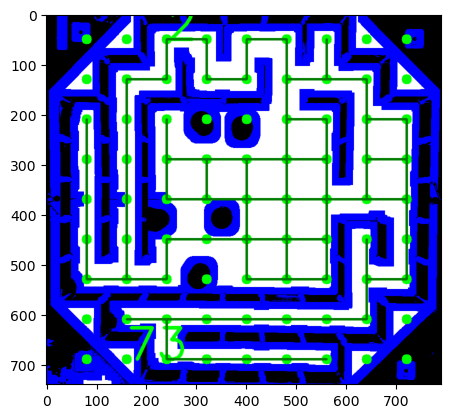

In [11]:
# Task 3.2: Implement BFS continued

# Run BFS and display the output
path = bfs(bfs_graph,bfs_start_node,bfs_end_node)

# Go through each pair of nodes along the path
for node in range(len(path) - 1):
    # Get the current node's coordinates
    node_1 = bfs_graph.nodes[path[node]]
    # Get the next node's coordinates
    node_2 = bfs_graph.nodes[path[node + 1]]
    x1, y1 = node_1.get_point()
    x2, y2 = node_2.get_point()
    
    # Connect the line
    cv2.line(bfs_image, (int(x1),int(y1)), (int(x2),int(y2)), (255, 0, 0), 6)

# Display the resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()

In [12]:
def node_to_coord(node_id, width=9):
    """Convert node ID to (row, col) coordinates in a width x width grid."""
    return (node_id // width, node_id % width)

def get_direction(from_node, to_node, width=9):
    """Return (row_change, col_change) from from_node to to_node."""
    r1, c1 = node_to_coord(from_node, width)
    r2, c2 = node_to_coord(to_node, width)
    return (r2 - r1, c2 - c1)

def turn_instructions(current_facing, desired_direction):
    """Return list of 'l' or 'r' needed to face desired_direction."""
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # Up, Right, Down, Left
    current_idx = directions.index(current_facing)
    desired_idx = directions.index(desired_direction)

    diff = (desired_idx - current_idx) % 4
    if diff == 0:
        return []           # No turn
    elif diff == 1:
        return ["r"]        # Turn right
    elif diff == 2:
        return ["r", "r"]   # Turn around
    elif diff == 3:
        return ["l"]        # Turn left

def path_to_instructions_string(path):
    instructions = []
    current_facing = (-1, 0)  # Start facing Up

    for i in range(len(path) - 1):
        from_node = path[i]
        to_node = path[i+1]

        desired_direction = get_direction(from_node, to_node)
        turns = turn_instructions(current_facing, desired_direction)
        instructions.extend(turns)
        instructions.append("f")  # Move forward

        current_facing = desired_direction

    return "".join(instructions)

# Example usage:
instr_string = path_to_instructions_string(path)
print(instr_string)
